In [61]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors

In [62]:
def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

rivnum 1 848.0
population 1 7919700.5
supply 1 17981137350.0
lonlat 1 Tokyo 139.69171 35.6895
cmy 1 2270.4314828572114
--------------------------------------------
rivnum 2 14.0
population 2 639264260.0
supply 2 1494143765568.0
lonlat 2 Delhi 77.21667 28.66667
cmy 2 2337.2865783504717
--------------------------------------------
rivnum 3 480.0
population 3 38796370.0
supply 3 16547958207.0
lonlat 3 Shanghai 121.45806 31.22222
cmy 3 426.5336952933326
--------------------------------------------
rivnum 4 164.0
population 4 6694303.5
supply 4 31631723586.0
lonlat 4 Ciudad de México (Mexico City) -99.141869 19.427318
cmy 4 4725.170226596389
--------------------------------------------
rivnum 5 5.0
population 5 90866180.0
supply 5 1592227789632.0
lonlat 5 São Paulo -46.63611 -23.5475
cmy 5 17522.777558417336
--------------------------------------------


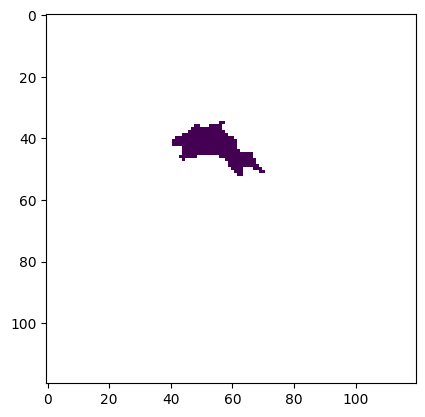

In [49]:
city_len = 5
ex_flg = False

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
pop_path = f'{h08dir}/global_city/dat/pop_tot_/GPW4ag__20100000.gl5'
pop = np.fromfile(pop_path, dtype='float32').reshape(2160, 4320)
riv_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
rivout = np.fromfile(riv_path, dtype='float32').reshape(2160, 4320)
rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320)
rivara_path = f'{h08dir}/global_city/dat/riv_ara_/rivara.CAMA.gl5'
rivara = np.fromfile(rivara_path, dtype='float32').reshape(2160, 4320)

msk_dir = f'{h08dir}/global_city/dat/vld_cty_'
cnt_dir = f'{h08dir}/global_city/dat/cty_cnt_/gpw4'
prf_dir = f'{h08dir}/global_city/dat/cty_prf_'

lonlat_path = f'{h08dir}/global_city/dat/cty_lst_/gpw4/WUP2018_300k_2010.txt'
with open(lonlat_path, "r") as input_file:
    lines = input_file.readlines()

CMY = []
world = np.zeros((2160, 4320))

for i in range(city_len):
    city_num = i+1
    #ctymsk_path = f'{msk_dir}/city_{city_num:08}.gl5'
    prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
    
    if not os.path.exists(prf_path):
        print(f'{i+1} is invalid prf')
        
    else:
        # rivnum
        #ctymsk = np.fromfile(ctymsk_path, dtype='float32').reshape(2160, 4320)
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
        rivnum_mask = np.ma.masked_where(prf == 0, rivnum)
        largest_rivnum = np.min(rivnum_mask)
        mask = (rivnum == largest_rivnum)
        print('rivnum', city_num, largest_rivnum)

        # population
        pop_basin = pop[mask]
        pop_sum = np.sum(pop_basin)
        print('population', city_num, pop_sum)

        # rivout
        rivara_masked = np.ma.masked_where(~mask, rivara)
        largest_rivara_index = np.argmax(rivara_masked)
        largest_rivara_coords = np.unravel_index(largest_rivara_index, rivara.shape)
        supply = rivout[largest_rivara_coords]
        supply_sum = np.sum(supply) * 60 * 60 * 24 * 365 / 1000
        print('supply', city_num, supply_sum)

        # lonlat
        line = lines[i]
        parts = line.split('\t')
        parts = [item.strip() for item in parts]
        cnt_lat = float(parts[1])
        cnt_lon = float(parts[2])
        city_name = parts[4].replace("\"", "").replace("?", "").replace("/", "")
        print('lonlat', city_num, city_name, cnt_lon, cnt_lat)

        # cmy = cubic meter(m3) per year(y)
        cmy = supply_sum/pop_sum
        CMY.append([city_num, cnt_lon, cnt_lat, cmy])
        print('cmy', city_num, cmy)
        print('--------------------------------------------')

        if np.sum(world[mask]) < 1:
            world[mask] = cmy
        
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(135, 145, 30, 40)
region = world[upperindex:lowerindex, leftindex:rightindex]
region_masked = np.ma.masked_where(region==0, region)
plt.imshow(region_masked)
plt.show()
    
if ex_flg is True:
    # save 1860 array
    cmy_array = np.array(CMY)
    savepath = f'{h08dir}/wsi/dat/cmy/cmy_basinlonlat.npy'
    np.save(savepath, cmy_array)
    print(f'{savepath} is saved')
    
    savepath = f'{h08dir}/wsi/dat/cmy/world_basingrid.npy'
    np.save(savepath, world)
    print(f'{savepath} is saved')

In [50]:
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
loadpath = f'{h08dir}/wsi/dat/cmy/world_basingrid.npy'
world_tmp = np.load(loadpath)
world_tmp_masked = np.ma.masked_where(world_tmp==0, world_tmp)

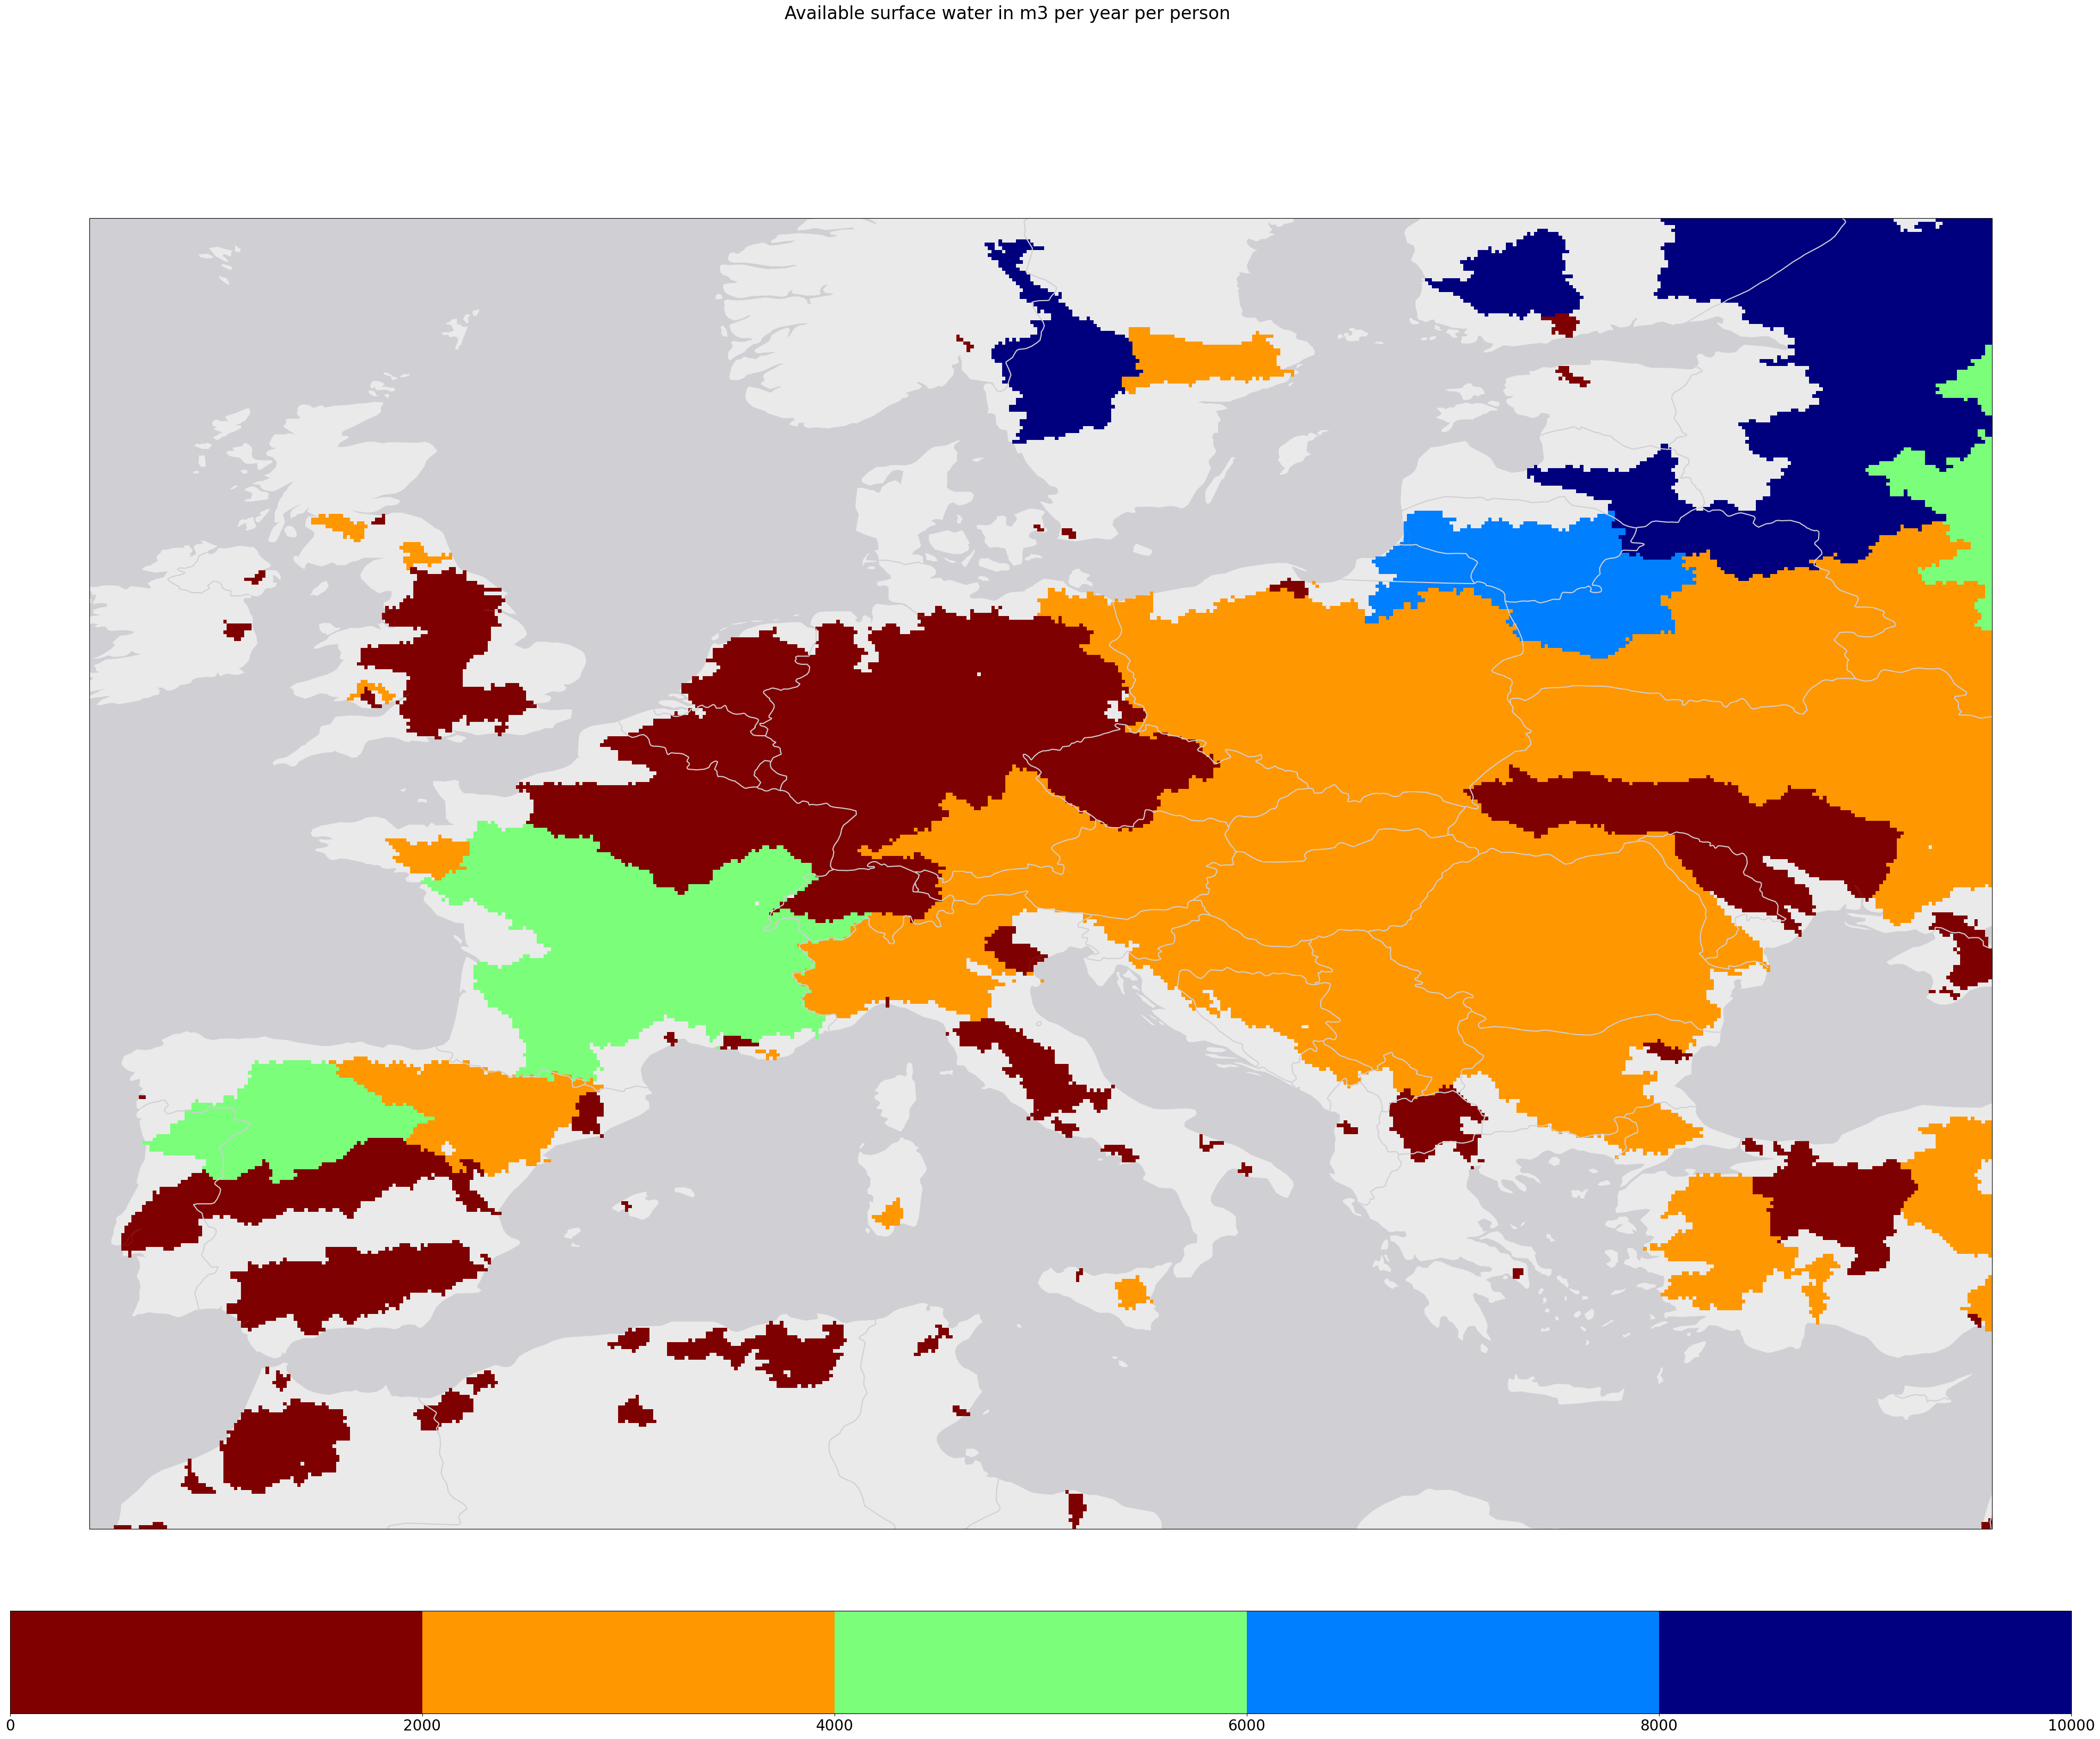

In [59]:
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(-10, 35, 32, 63)
region = world_tmp[upperindex:lowerindex, leftindex:rightindex]
region_masked = np.ma.masked_where(region==0, region)

color_num = 5
bnd_max = 1e4
cmap = plt.get_cmap('jet_r', color_num)  # 10個の離散値
bounds = np.linspace(0, bnd_max, color_num+1)  # 範囲を10分割
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.rcParams["font.size"] = 20
projection = ccrs.PlateCarree(central_longitude=0)
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(50,40), subplot_kw={'projection': projection})
img = ax.imshow(region_masked, 
              cmap= cmap,
              norm = norm,
              extent=img_extent,
              transform=ccrs.PlateCarree(), 
             )
ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea')
ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#d0cfd4')
ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4')
ax.gridlines(visible=False)
cbar = fig.colorbar(img, ax=ax, orientation='horizontal', pad=0.05)
fig.suptitle('Available surface water in m3 per year per person')
plt.show()

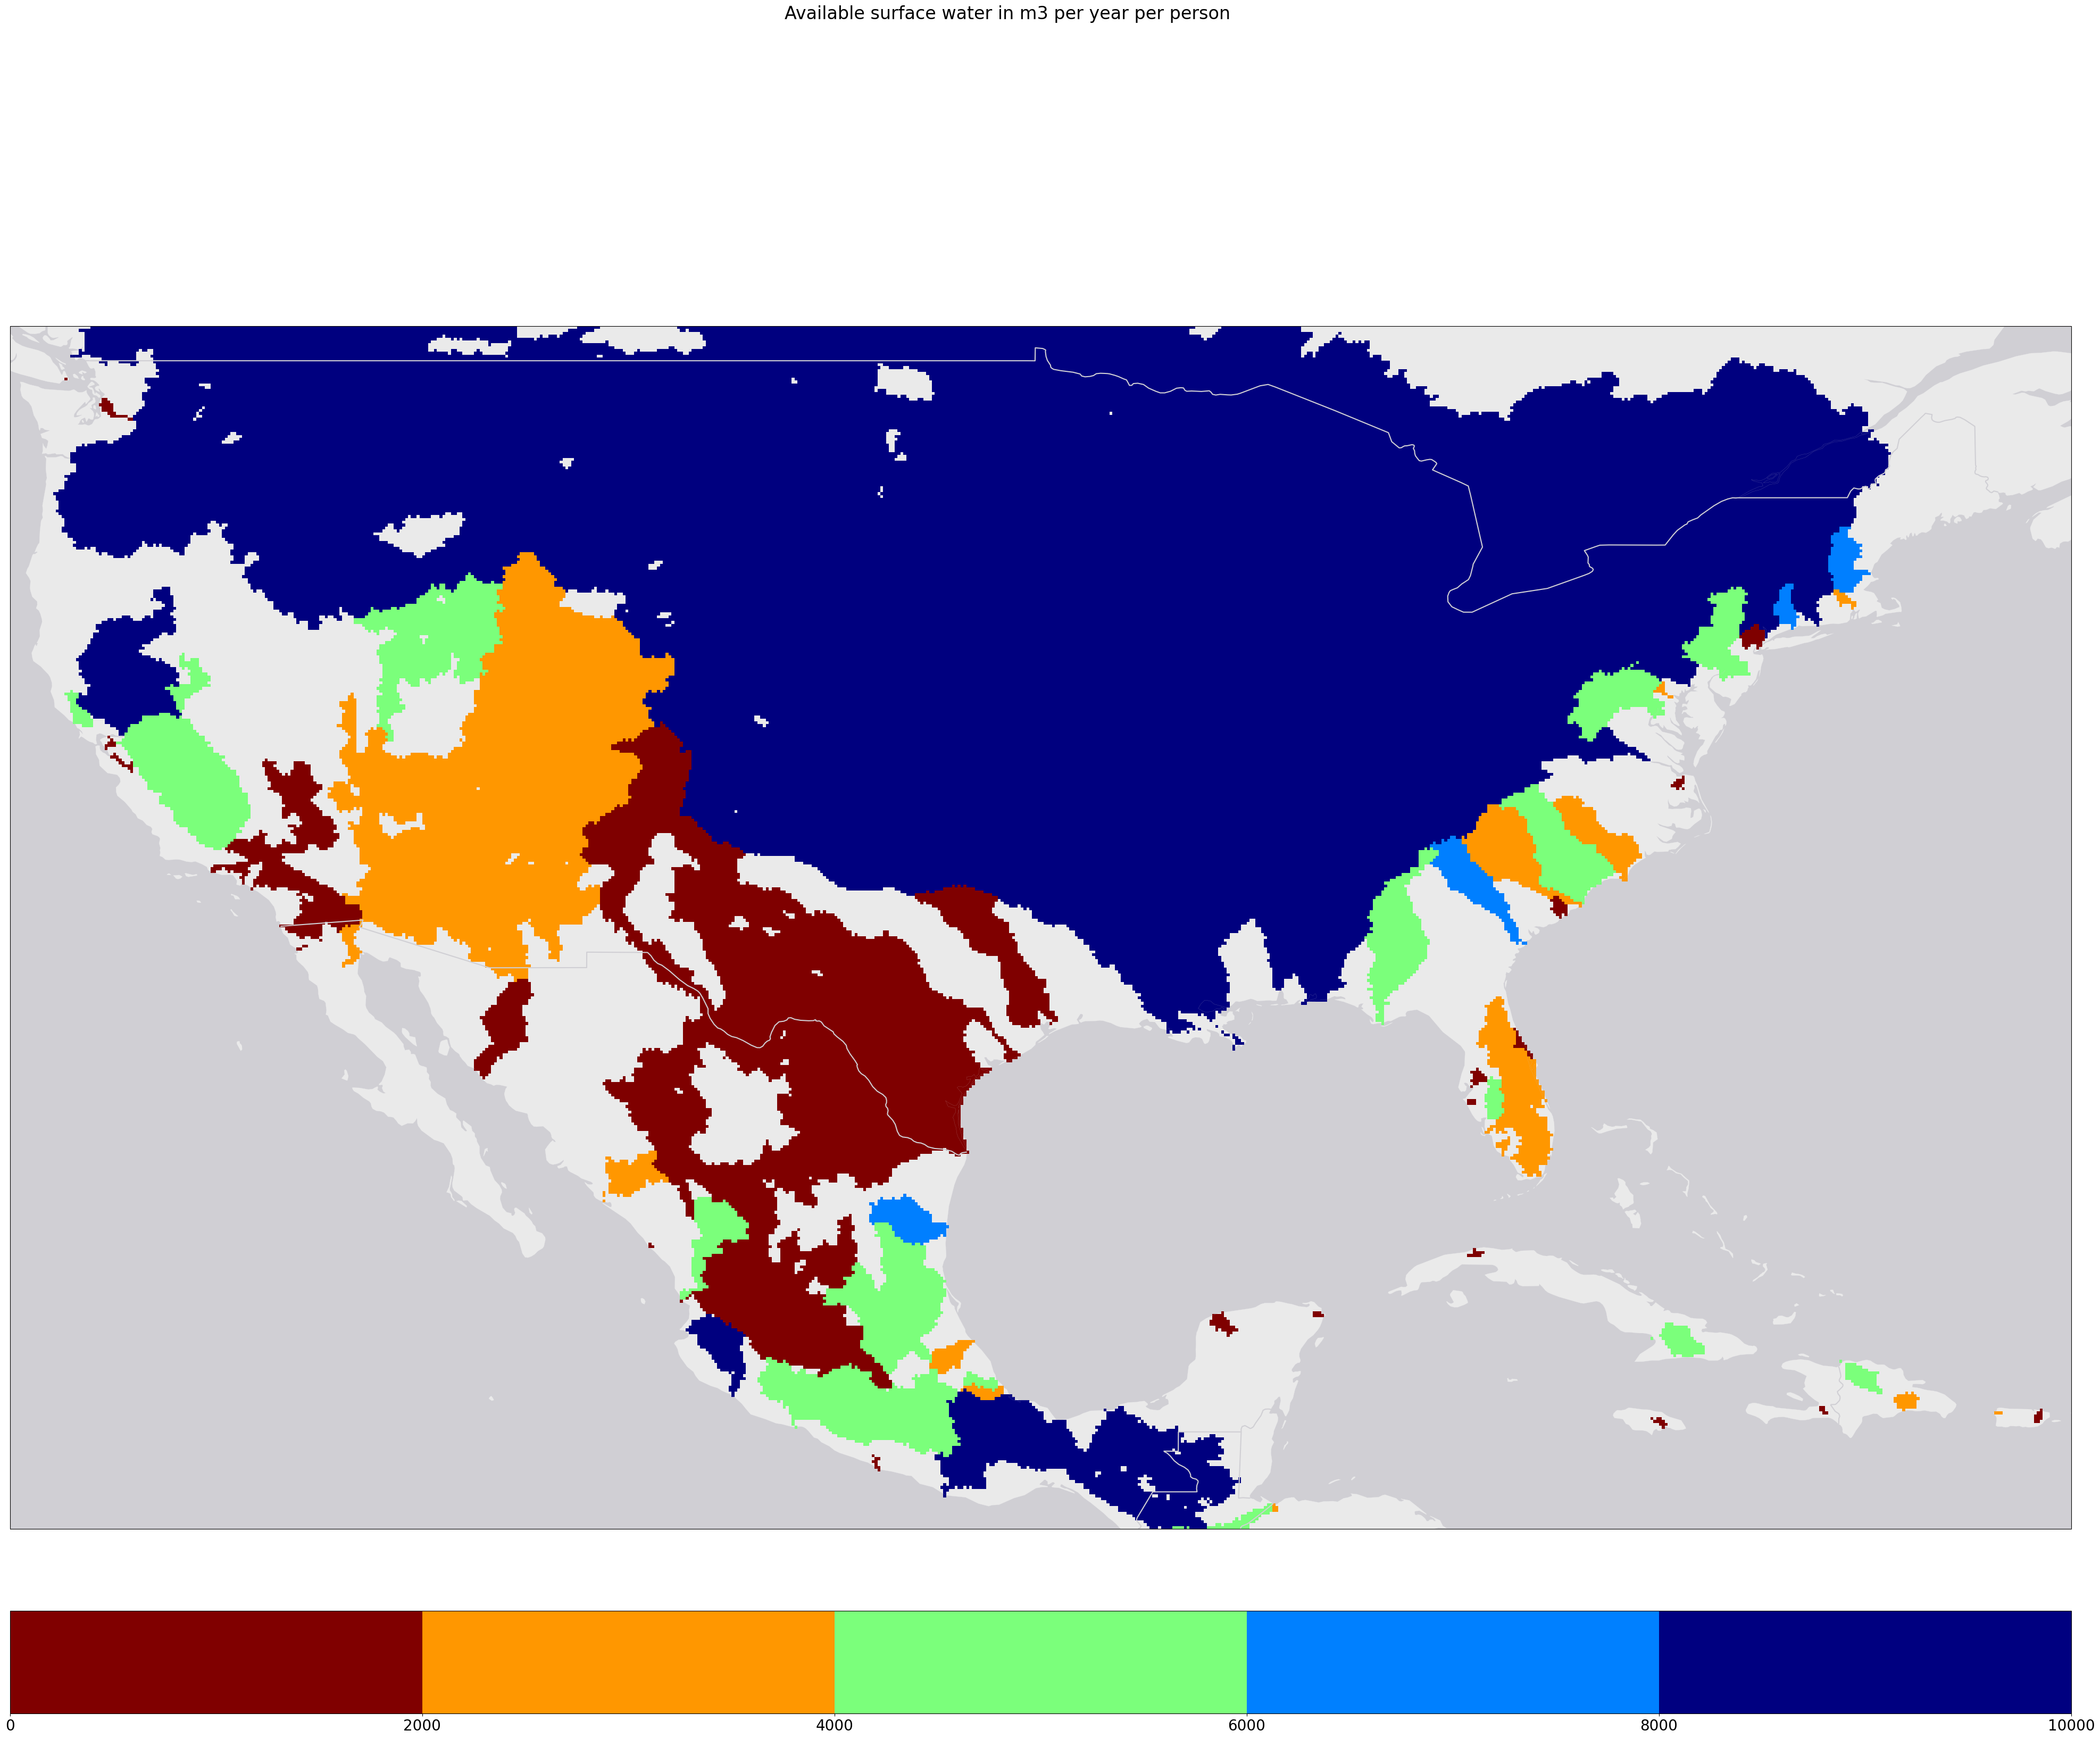

In [58]:
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(-125, -65, 15, 50)
region = world_tmp[upperindex:lowerindex, leftindex:rightindex]
region_masked = np.ma.masked_where(region==0, region)

color_num = 5
bnd_max = 1e4
cmap = plt.get_cmap('jet_r', color_num)  # 10個の離散値
bounds = np.linspace(0, bnd_max, color_num+1)  # 範囲を10分割
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.rcParams["font.size"] = 20
projection = ccrs.PlateCarree(central_longitude=0)
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(50,40), subplot_kw={'projection': projection})
img = ax.imshow(region_masked, 
              cmap= cmap,
              norm = norm,
              extent=img_extent,
              transform=ccrs.PlateCarree(), 
             )
ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea')
ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#d0cfd4')
ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4')
ax.gridlines(visible=False)
cbar = fig.colorbar(img, ax=ax, orientation='horizontal', pad=0.05)
fig.suptitle('Available surface water in m3 per year per person')
plt.show()

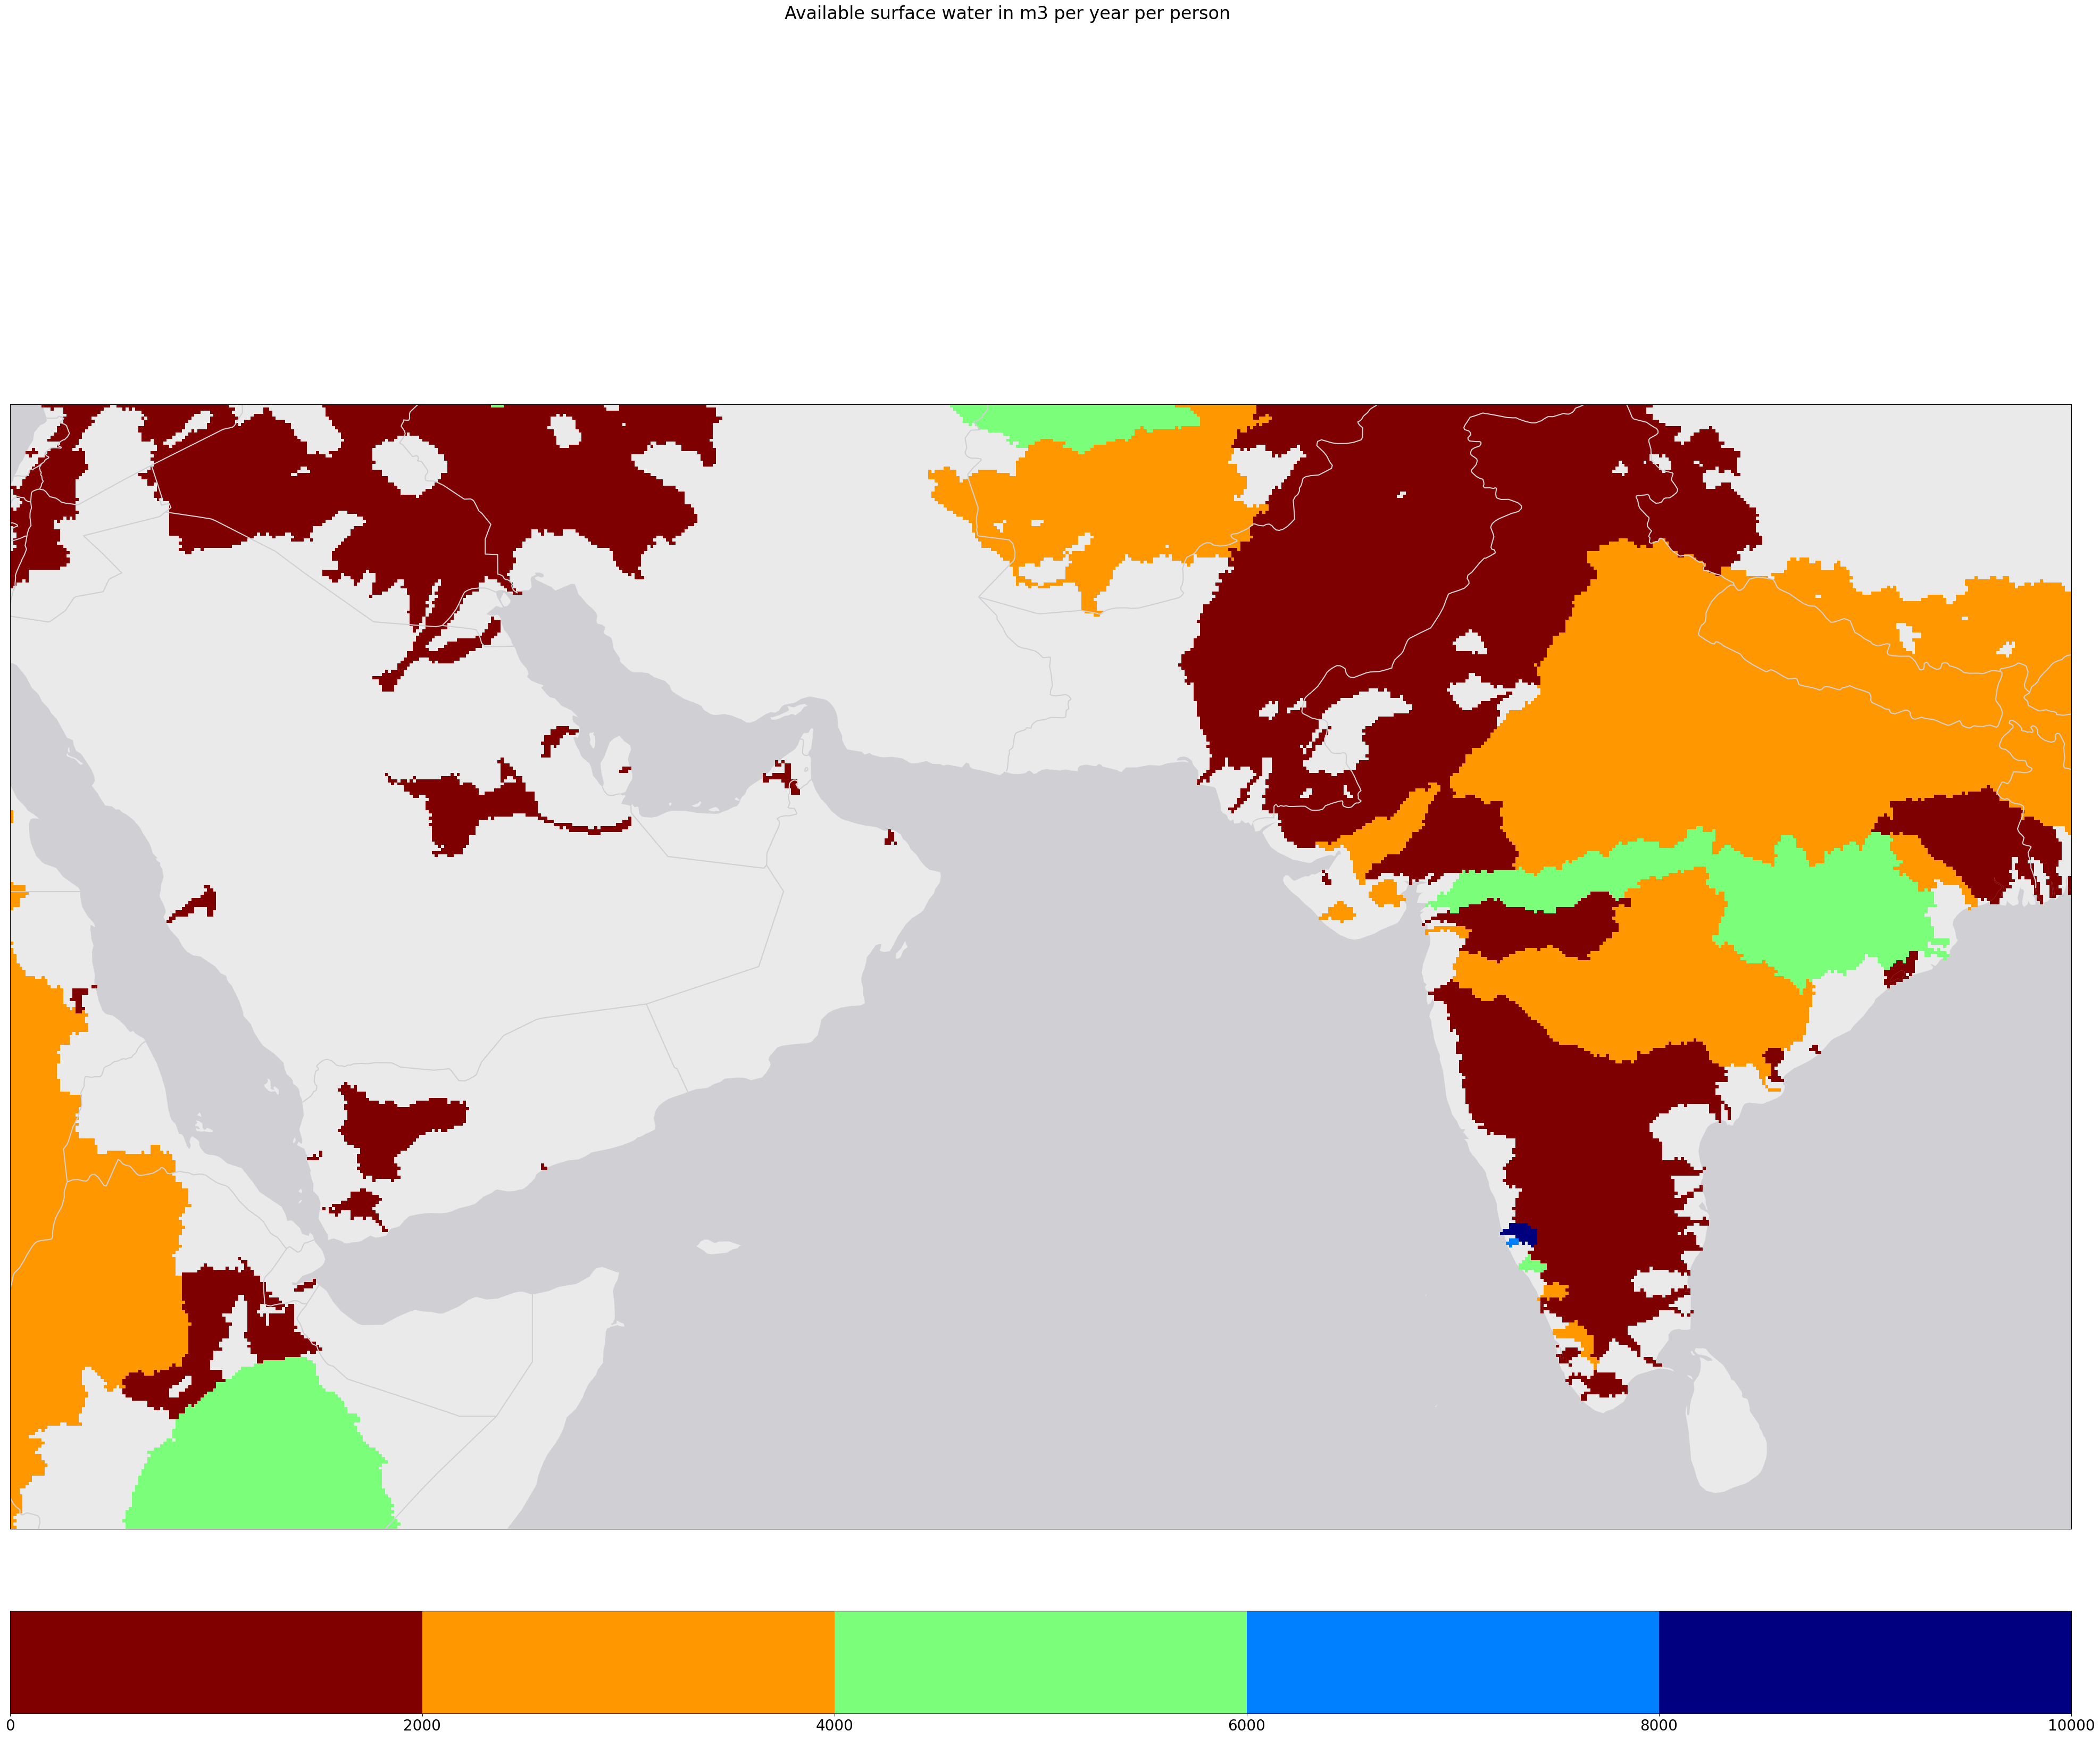

In [60]:
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(35, 90, 5, 35)
region = world_tmp[upperindex:lowerindex, leftindex:rightindex]
region_masked = np.ma.masked_where(region==0, region)

color_num = 5
bnd_max = 1e4
cmap = plt.get_cmap('jet_r', color_num)  # 10個の離散値
bounds = np.linspace(0, bnd_max, color_num+1)  # 範囲を10分割
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.rcParams["font.size"] = 20
projection = ccrs.PlateCarree(central_longitude=0)
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(50,40), subplot_kw={'projection': projection})
img = ax.imshow(region_masked, 
              cmap= cmap,
              norm = norm,
              extent=img_extent,
              transform=ccrs.PlateCarree(), 
             )
ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea')
ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#d0cfd4')
ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4')
ax.gridlines(visible=False)
cbar = fig.colorbar(img, ax=ax, orientation='horizontal', pad=0.05)
fig.suptitle('Available surface water in m3 per year per person')
plt.show()

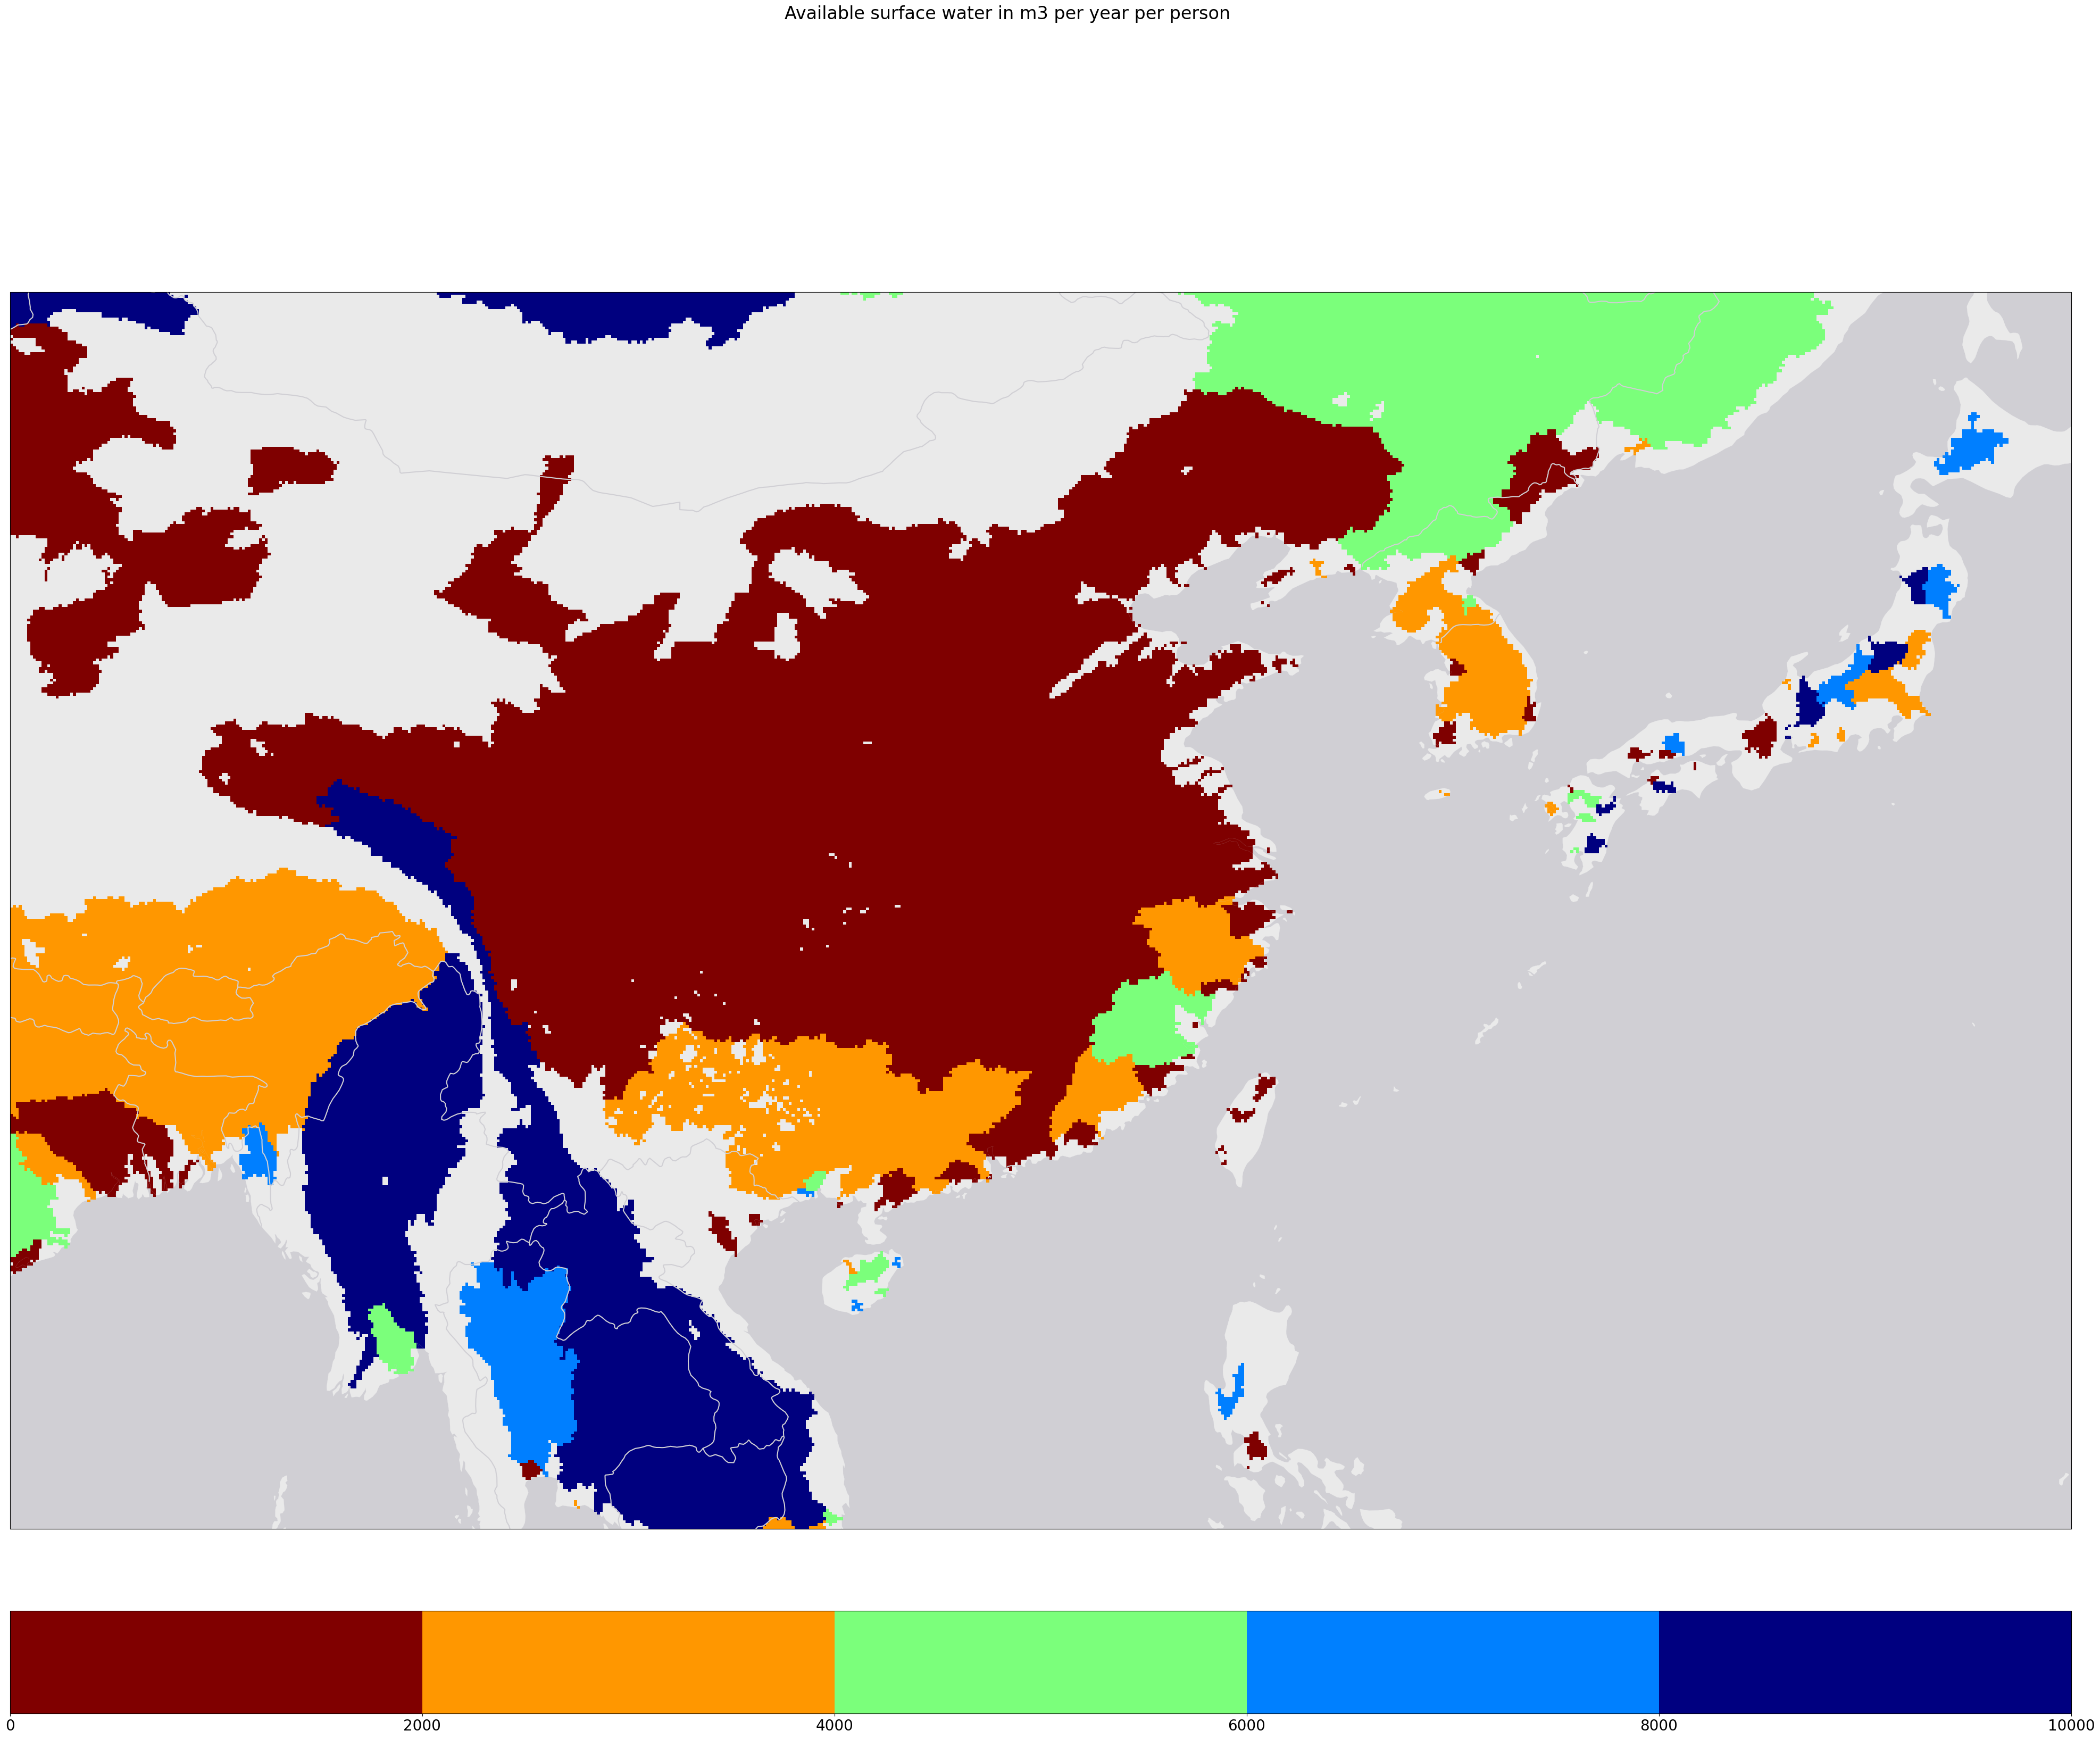

In [54]:
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(85, 145, 12, 48)
region = world_tmp[upperindex:lowerindex, leftindex:rightindex]
region_masked = np.ma.masked_where(region==0, region)

color_num = 5
bnd_max = 1e4
cmap = plt.get_cmap('jet_r', color_num)  # 10個の離散値
bounds = np.linspace(0, bnd_max, color_num+1)  # 範囲を10分割
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.rcParams["font.size"] = 20
projection = ccrs.PlateCarree(central_longitude=0)
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(50,40), subplot_kw={'projection': projection})
img = ax.imshow(region_masked, 
              cmap= cmap,
              norm = norm,
              extent=img_extent,
              transform=ccrs.PlateCarree(), 
             )
ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea')
ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#d0cfd4')
ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4')
ax.gridlines(visible=False)
cbar = fig.colorbar(img, ax=ax, orientation='horizontal', pad=0.05)
fig.suptitle('Available surface water in m3 per year per person')
plt.show()